In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Skip this cell if CSR2D/ is already added under PYHTONPATH 
import os, sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)  

# Function definitions

In [44]:
import mpmath as mp
import numpy as np
import cupy as cp
import sys

import matplotlib.pyplot as plt

from scipy.ndimage import convolve as conv
from scipy.signal import convolve2d, fftconvolve, oaconvolve
from cupyx.scipy.ndimage import convolve as cupy_conv

from csr2d.core import psi_s, psi_x
from csr2d.dist import lambda_p_Gauss
   

In [29]:
def is_even(n):
    if n % 2 == 0:
        return -1
    else:
        return 0
a = np.array([[1, 2, 0, 0,2],[5, 3, 0, 4,5],[0, 0, 0, 7,3],[9, 3, 0, 0,2]])
(is_even(a.shape[0]),is_even(a.shape[1]))

(-1, 0)

In [46]:
def Ws(gamma, rho, sigmaz, sigmax, dz, dx, method='oa', xp=np, cupy_conv=None):
    """
    Apply 2D convolution to compute the longitudinal wake Ws on a grid 
    Also returns the zvec and xvec which define the grid
    
    Still needs to improve the convolution step
    """
    beta = (1-1/gamma**2)**(1/2)
    if method == 'cupy':
        pass
    elif method == 'oa':
        conv_method = oaconvolve
    elif method == 'fft':
        conv_method = fftconvolve
    elif method == '2d':
        conv_method = convolve2d
    else:
        print('Invalid convolution method specified!!')
        sys.exit("Exiting...")
    
    print('Here A')
    # Creating the grid of the z-derivative of the bunch distribution
    zvec = np.arange(-5*sigmaz, 5*sigmaz, dz)
    xvec = np.arange(-5*sigmax, 5*sigmax, dx)
    lambdap_list = [[lambda_p_Gauss(i,j) for j in xvec] for i in zvec] 
    lambdap_grid = xp.array(lambdap_list,dtype=float)
    
    print('Here B')
    # Creating the grid of the potential 
    zvec2 = np.arange(-10*sigmaz, 10*sigmaz, dz)
    xvec2 = np.arange(-10*sigmax, 10*sigmax, dx)
    psi_s_list = [[psi_s(i/2/rho,j,beta) for j in xvec2] for i in zvec2]   
    psi_s_grid = xp.array(psi_s_list,dtype=float)
    
    print('Here C')
    # Convolution
    if method == 'cupy':
        #origin = (is_even(psi_s_grid.shape[0]),is_even(psi_s_grid.shape[1]))
        #conv_s = cupy_conv(lambdap_grid, psi_s_grid, mode='constant',origin=origin)
        conv_s = cupy_conv(lambdap_grid, psi_s_grid, mode='constant')
    else:
        #conv_s = conv_method(lambdap_grid, psi_s_grid, mode='same', boundary='fill', fillvalue=0)
        conv_s = conv_method(lambdap_grid, psi_s_grid, mode='same')
        
    WsConv = (beta**2/rho)*(conv_s)*(dz*dx)
   
    return zvec, xvec, WsConv

# Testing

In [40]:
gamma = 500
rho = 1
sigmax = 10E-6
sigmaz = 10E-6

# Adjust the step size here
# Small steps might greatly increase computation time...
#dz = 0.1*sigmaz
#dx = 0.1*sigmax

N = 300
dz = 1.0E-4/N
dx = 1.0E-4/N

In [32]:
# Find index where zvec returns one sigma_z
temp=abs(zvec-1*sigmaz)
zix_1sig = np.where(temp == temp.min())[0][0] 
print(zix_1sig)
print(zvec[zix_1sig])

60
9.99999999999983e-06


## single run testing

In [51]:
%%time
zvec, xvec, WsConv = Ws(gamma, rho, sigmaz, sigmax, dz, dx, method='cupy', xp=cp, cupy_conv=cupy_conv)

Here A
Here B
Here C
CPU times: user 28.8 s, sys: 31.5 ms, total: 28.8 s
Wall time: 28.8 s


In [39]:
# Checking the result is a cupy entity
WsConv.__class__

cupy.core.core.ndarray

In [46]:
temp=abs(zvec)
zix_0 = np.where(temp == temp.min())[0][0] 
temp=abs(zvec-1*sigmaz)
zix_1sig = np.where(temp == temp.min())[0][0] 
temp=abs(zvec-2*sigmaz)
zix_2sig = np.where(temp == temp.min())[0][0] 

temp=abs(xvec)
xix_0 = np.where(temp == temp.min())[0][0] 
temp=abs(xvec-1*sigmax)
xix_1sig = np.where(temp == temp.min())[0][0] 
temp=abs(xvec-2*sigmax)
xix_2sig = np.where(temp == temp.min())[0][0] 

print(WsConv.shape)
print(zix_0)
print(zix_1sig)
print(zix_2sig)
print(WsConv[zix_0,xix_0])
print(WsConv[zix_1sig,xix_0])
print(WsConv[zix_2sig,xix_0])
print(WsConv[zix_0,xix_1sig])
print(WsConv[zix_0,xix_2sig])
WsConv.__class__

(1000, 1000)
500
600
700
-2581476.028033264
-331727.2006581599
809164.7062662508
-2614685.729772971
-2646981.452372715


cupy.core.core.ndarray

In [42]:
%%time
zvec, xvec, WsConv = Ws(gamma, rho, sigmaz, sigmax, dz, dx, 'oa')

CPU times: user 28.9 s, sys: 27.5 ms, total: 29 s
Wall time: 28.9 s


In [89]:
print(WsConv[zix_min,xix_min])
WsConv.__class__

-2677061.3108137683


numpy.ndarray

In [50]:
%%time 
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'fft')

Here A
Here B
Here C
CPU times: user 28.7 s, sys: 34.4 ms, total: 28.7 s
Wall time: 28.7 s


In [91]:
print(WsConv[zix_min,xix_min])
WsConv.__class__

-2677061.3108137683


numpy.ndarray

## timing test

In [6]:
%%timeit -n 3 -r 3
Ws(gamma, rho, sigmaz, sigmax, dz, dx, method='cupy', xp=cp, cupy_conv=cupy_conv)

7min 17s ± 1.33 s per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [4]:
%%timeit -n 3 -r 3
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'oa')

12min 32s ± 6.84 s per loop (mean ± std. dev. of 3 runs, 3 loops each)


# I/O

In [18]:
print(zvec.shape[0])
print(xvec.shape[0])

401
401


In [47]:
size = 1000

# cp doesn't have savetxt function, so load it to npy first hten use np to write
cp.save('temp.npy',WsConv)
dat = np.load('temp.npy')
np.savetxt('WsConv_'+str(size)+'.txt',dat)

# Below is Scratch for now

In [39]:
zvec_abs=abs(zvec)
zix_min = np.where(abs(zvec_abs) == zvec_abs.min())[0][0] # find the index for which xvec[index] is closest to zero
xvec_abs=abs(xvec)
xix_min = np.where(abs(xvec_abs) == xvec_abs.min())[0][0]

WsConv[zix_min,xix_min] # returns Ws(~0,~0)

-2637000.1166977924

In [45]:
WsConv.__class__

cupy.core.core.ndarray

In [46]:
cp.save('t1.npy',WsConv)

In [48]:
dat = np.load('t1.npy')
np.savetxt('text.txt',dat)

In [56]:
np.save('test',WsConv)
np.load('test.npy');

## Vectorize from Chris

In [37]:
@np.vectorize
def mf(a,b):
    return lambda_p_Gauss(a,b)
vf = np.vectorize(mf)
vf([[0.00001,0.00002],[0.00003,0.00004]] , [[0.00001,0.00002],[0.0003,0.00004]])

array([[array(mpf('-58549831524319.141'), dtype=object),
        array(mpf('-5830048930056.3857'), dtype=object)],
       [array(mpf('-1.959292884786357e-183'), dtype=object),
        array(mpf('-71642117.313120723'), dtype=object)]], dtype=object)

Text(0, 0.5, 'Ws$(10^6 m^{-2})$')

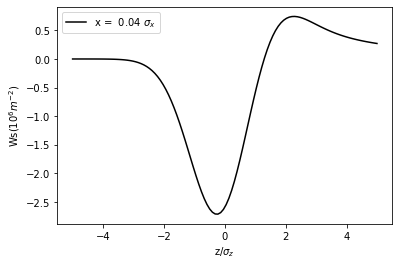

In [58]:
zvec_abs=abs(zvec)
zix_min = np.where(abs(zvec_abs) == zvec_abs.min())[0][0] # find the index for which xvec[index] is closest to zero
xvec_abs=abs(xvec)
xix_min = np.where(abs(xvec_abs) == xvec_abs.min())[0][0]

plt.plot(zvec/sigmaz, WsConv[:,int(xix_min)]/1e6, '-', color='black', label=f"x = {xvec[xix_min]/sigmax:5.2f} $\sigma_x$");
plt.legend(loc='upper left')
plt.xlabel('z/$\sigma_z$')
plt.ylabel('Ws$(10^6 m^{-2})$')

In [ ]:
%timeit -n 3 -r 4 ndimage.convolve(a, k, mode='constant', cval=0.0)
%timeit -n 3 -r 4 signal.convolve2d(a, k, mode='same')
%timeit -n 3 -r 4 fftconvolve(a, k, mode='same')
%timeit -n 3 -r 4 oaconvolve(a, k, mode='same')

a = cp.random.randint(5, size=(N, N))
k = cp.random.randint(5, size=(2*N, 2*N))
%timeit -n 3 -r 4 filters.convolve(a, k, mode='constant', cval=0.0)

In [20]:
from scipy.ndimage import convolve as conv
from scipy.signal import convolve2d, fftconvolve, oaconvolve
a = np.array([[1, 2, 0, 0],[5, 3, 0, 4],[0, 0, 0, 7],[9, 3, 0, 0]])
k = np.array([[1,1,1,1,1],[1,1,1,1,0],[1,1,1,0,0],[1,1,0,0,0],[1,0,0,0,0]])
print(conv(a, k, mode='constant', cval=0.0))

[[11 21 14 11]
 [22 26 23 14]
 [15 23 14  7]
 [12 14  7  0]]


In [23]:
a = cp.array([[1, 2, 0, 0],[5, 3, 0, 4],[0, 0, 0, 7],[9, 3, 0, 0]])
k = cp.array([[1,1,1,1,1],[1,1,1,1,0],[1,1,1,0,0],[1,1,0,0,0],[1,0,0,0,0]])
print(cupy_conv(a, k, mode='constant', cval=0.0))

[[11 21 14 11]
 [22 26 23 14]
 [15 23 14  7]
 [12 14  7  0]]
